In [155]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation 
from matplotlib import colors
from celluloid import Camera
import time
from scipy import interpolate

In [148]:
def move(location, lattice):
    state = lattice[location]
    direction = np.random.randint(4)

    #move up, y < n - 1
    if direction == 0 and location[1] < len(lattice[0]) - 1:
        if lattice[(location[0],location[1]+1)] == 0:
            lattice[(location[0],location[1]+1)] = state
            lattice[location] = 0
    #move down, y > 0
    if direction == 1 and location[1] > 0:
        if lattice[(location[0],location[1]-1)] == 0:
            lattice[(location[0],location[1]-1)] = state
            lattice[location] = 0
    #move right, x < n - 1
    if direction == 2 and location[0] < len(lattice) - 1:
        if lattice[(location[0]+1,location[1])] == 0:
            lattice[(location[0]+1,location[1])] = state
            lattice[location] = 0
    #move left, x > 0
    if direction == 3 and location[0] > 0:
        if lattice[(location[0]-1,location[1])] == 0:
            lattice[(location[0]-1,location[1])] = state
            lattice[location] = 0

def infect(location, lattice):
    direction = np.random.randint(4)

    #infect up, y < n - 1
    if direction == 0 and location[1] < len(lattice) - 1:
        if lattice[(location[0],location[1]+1)] == 1:
            lattice[(location[0],location[1]+1)] = 2
    #infect down, y > 0
    if direction == 1 and location[1] > 0:
        if lattice[(location[0],location[1]-1)] == 1:
            lattice[(location[0],location[1]-1)] = 2
    #infect right, x < n - 1
    if direction == 2 and location[0] < len(lattice) - 1:
        if lattice[(location[0]+1,location[1])] == 1:
            lattice[(location[0]+1,location[1])] = 2
    #infect left, x > 0
    if direction == 3 and location[0] > 0:
        if lattice[(location[0]-1,location[1])] == 1:
            lattice[(location[0]-1,location[1])] = 2

def get_random_agent_location(lattice, infectedOnly=False):
    if infectedOnly:
        individuals = np.where(lattice==2)
    else:
        individuals = np.where(lattice!=0)
    
    #print(np.random.randint(len(individuals[0])))
    random_individual_index = np.random.randint(len(individuals[0]))
    location = (individuals[0][random_individual_index], individuals[1][random_individual_index])
    return location

In [281]:
def SIR_ABM(pi = 0.1, pm = 1.0, pr = 0.01, n = 20, T=5, s0 = 0.49, i0 = 0.01, r0 = 0.00, snapshot_num = 60):

    #initialise array with individuals (S = 1, I = 2, R = 3)
    #1d array with required number of individuals
    A = np.zeros((n**2))
    S_num = int(np.ceil(s0 * n**2))
    I_num = int(np.ceil(i0 * n**2))
    R_num = int(np.ceil(r0 * n**2))
    total = S_num+I_num+R_num
    A[:S_num] = 1
    A[S_num:S_num+I_num] = 2
    A[S_num + I_num:S_num + I_num + R_num] = 3
    #shuffle and reshape to 2d
    np.random.shuffle(A)
    A = A.reshape(n,n)

    #time
    t = 0
    max_time = T/pr

    #lists, st is list of indexes of snapshot times, so that t[st[i]] gives time of i'th snapshot of A
    t_list = [t]
    S_list = [S_num]
    I_list = [I_num]
    R_list = [R_num]
    A_list = [np.copy(A)]
    st_list = [t]

    #snapshot
    snapshot_count = 0
    count = 0

    while t < max_time:
        #decide which event takes place and advance time
        a = pm*(S_num+I_num+R_num) + pi*I_num + pr*I_num
        step = -np.log(np.random.uniform())/a
        t += step
        event = a*np.random.uniform()

        if event <= pm*(S_num+I_num+R_num):
            #movement
            loc = get_random_agent_location(A)
            move(loc, A)
        elif (pm*(S_num+I_num+R_num) < event) and  (event <= pm*(S_num+I_num+R_num) + pi*I_num):
            #infection
            loc = get_random_agent_location(A, infectedOnly=True)
            infect(loc, A)
        elif (pm*(S_num+I_num+R_num) + pi*I_num < event) and  (event <= pm*(S_num+I_num+R_num) + pi*I_num + pr*I_num):
            #recovery
            loc = get_random_agent_location(A, infectedOnly=True)
            A[loc] = 3
        
        count += 1

        S_num = np.sum(A==1)
        I_num = np.sum(A==2)
        R_num = np.sum(A==3)
        total = S_num+I_num+R_num

        t_list.append(t)
        S_list.append(S_num)
        I_list.append(I_num)
        R_list.append(R_num)
        if t > snapshot_count*max_time/snapshot_num:
            A_list.append(np.copy(A))
            st_list.append(count)
            snapshot_count+=1

    return S_list, I_list, R_list, t_list, A_list, st_list

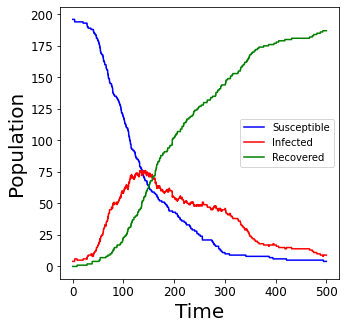

In [283]:
#plot SIR graph
pr = 0.01
S, I, R, t, A, st = SIR_ABM(n=20, pr=pr)
t = np.array(t)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Population', fontsize=20)
ax.tick_params(axis='both', labelsize=12)
susc, = ax.plot(t[::4],S[::4], 'b', label='Susceptible')
inf, = ax.plot(t[::4],I[::4], 'r', label='Infected')
rec, = ax.plot(t[::4],R[::4], 'g', label='Recovered')
legend = ax.legend()

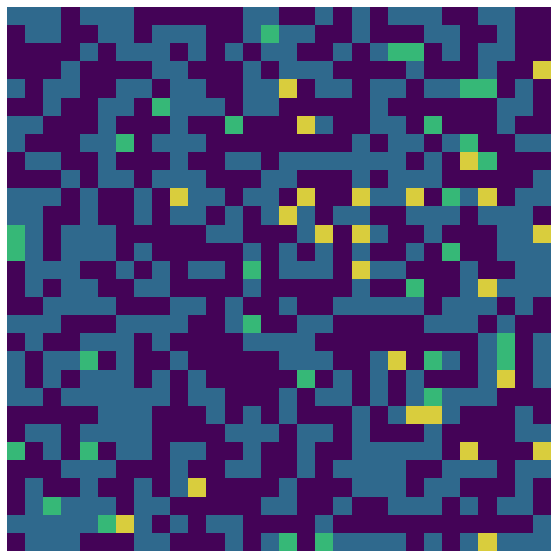

In [5]:
##anim lattice
#for large n, snapshot_num, will take a long time
A_list = SIR_ABM(n=30, snapshot_num=20)[4]
fig = plt.figure(figsize=(10,10))
plt.axis('off')
camera=Camera(fig)
for copy in A_list:
    if len(np.where(copy==3)[0])==0:
        cmap = colors.ListedColormap(['#440357','#d9cd3d','#36B877'])
    else:
        cmap = colors.ListedColormap(['#440357','#d9cd3d','#36B877','#2F698D'])
    plt.imshow(copy, cmap=cmap)
    camera.snap()

anim = camera.animate()
anim.save('test_anims/test1.mp4', writer='ffmpeg', fps=30)

simulating
simulated in 2.7646 seconds
plotting
plot 1 out of 22
plot 2 out of 22
plot 3 out of 22
plot 4 out of 22
plot 5 out of 22
plot 6 out of 22
plot 7 out of 22
plot 8 out of 22
plot 9 out of 22
plot 10 out of 22
plot 11 out of 22
plot 12 out of 22
plot 13 out of 22
plot 14 out of 22
plot 15 out of 22
plot 16 out of 22
plot 17 out of 22
plot 18 out of 22
plot 19 out of 22
plot 20 out of 22
plot 21 out of 22
plot 22 out of 22
generated plots in 0.4288 seconds
saving
frame 1 out of 22
frame 2 out of 22
frame 3 out of 22
frame 4 out of 22
frame 5 out of 22
frame 6 out of 22
frame 7 out of 22
frame 8 out of 22
frame 9 out of 22
frame 10 out of 22
frame 11 out of 22
frame 12 out of 22
frame 13 out of 22
frame 14 out of 22
frame 15 out of 22
frame 16 out of 22
frame 17 out of 22
frame 18 out of 22
frame 19 out of 22
frame 20 out of 22
frame 21 out of 22
frame 22 out of 22
saved in 46.4101 seconds


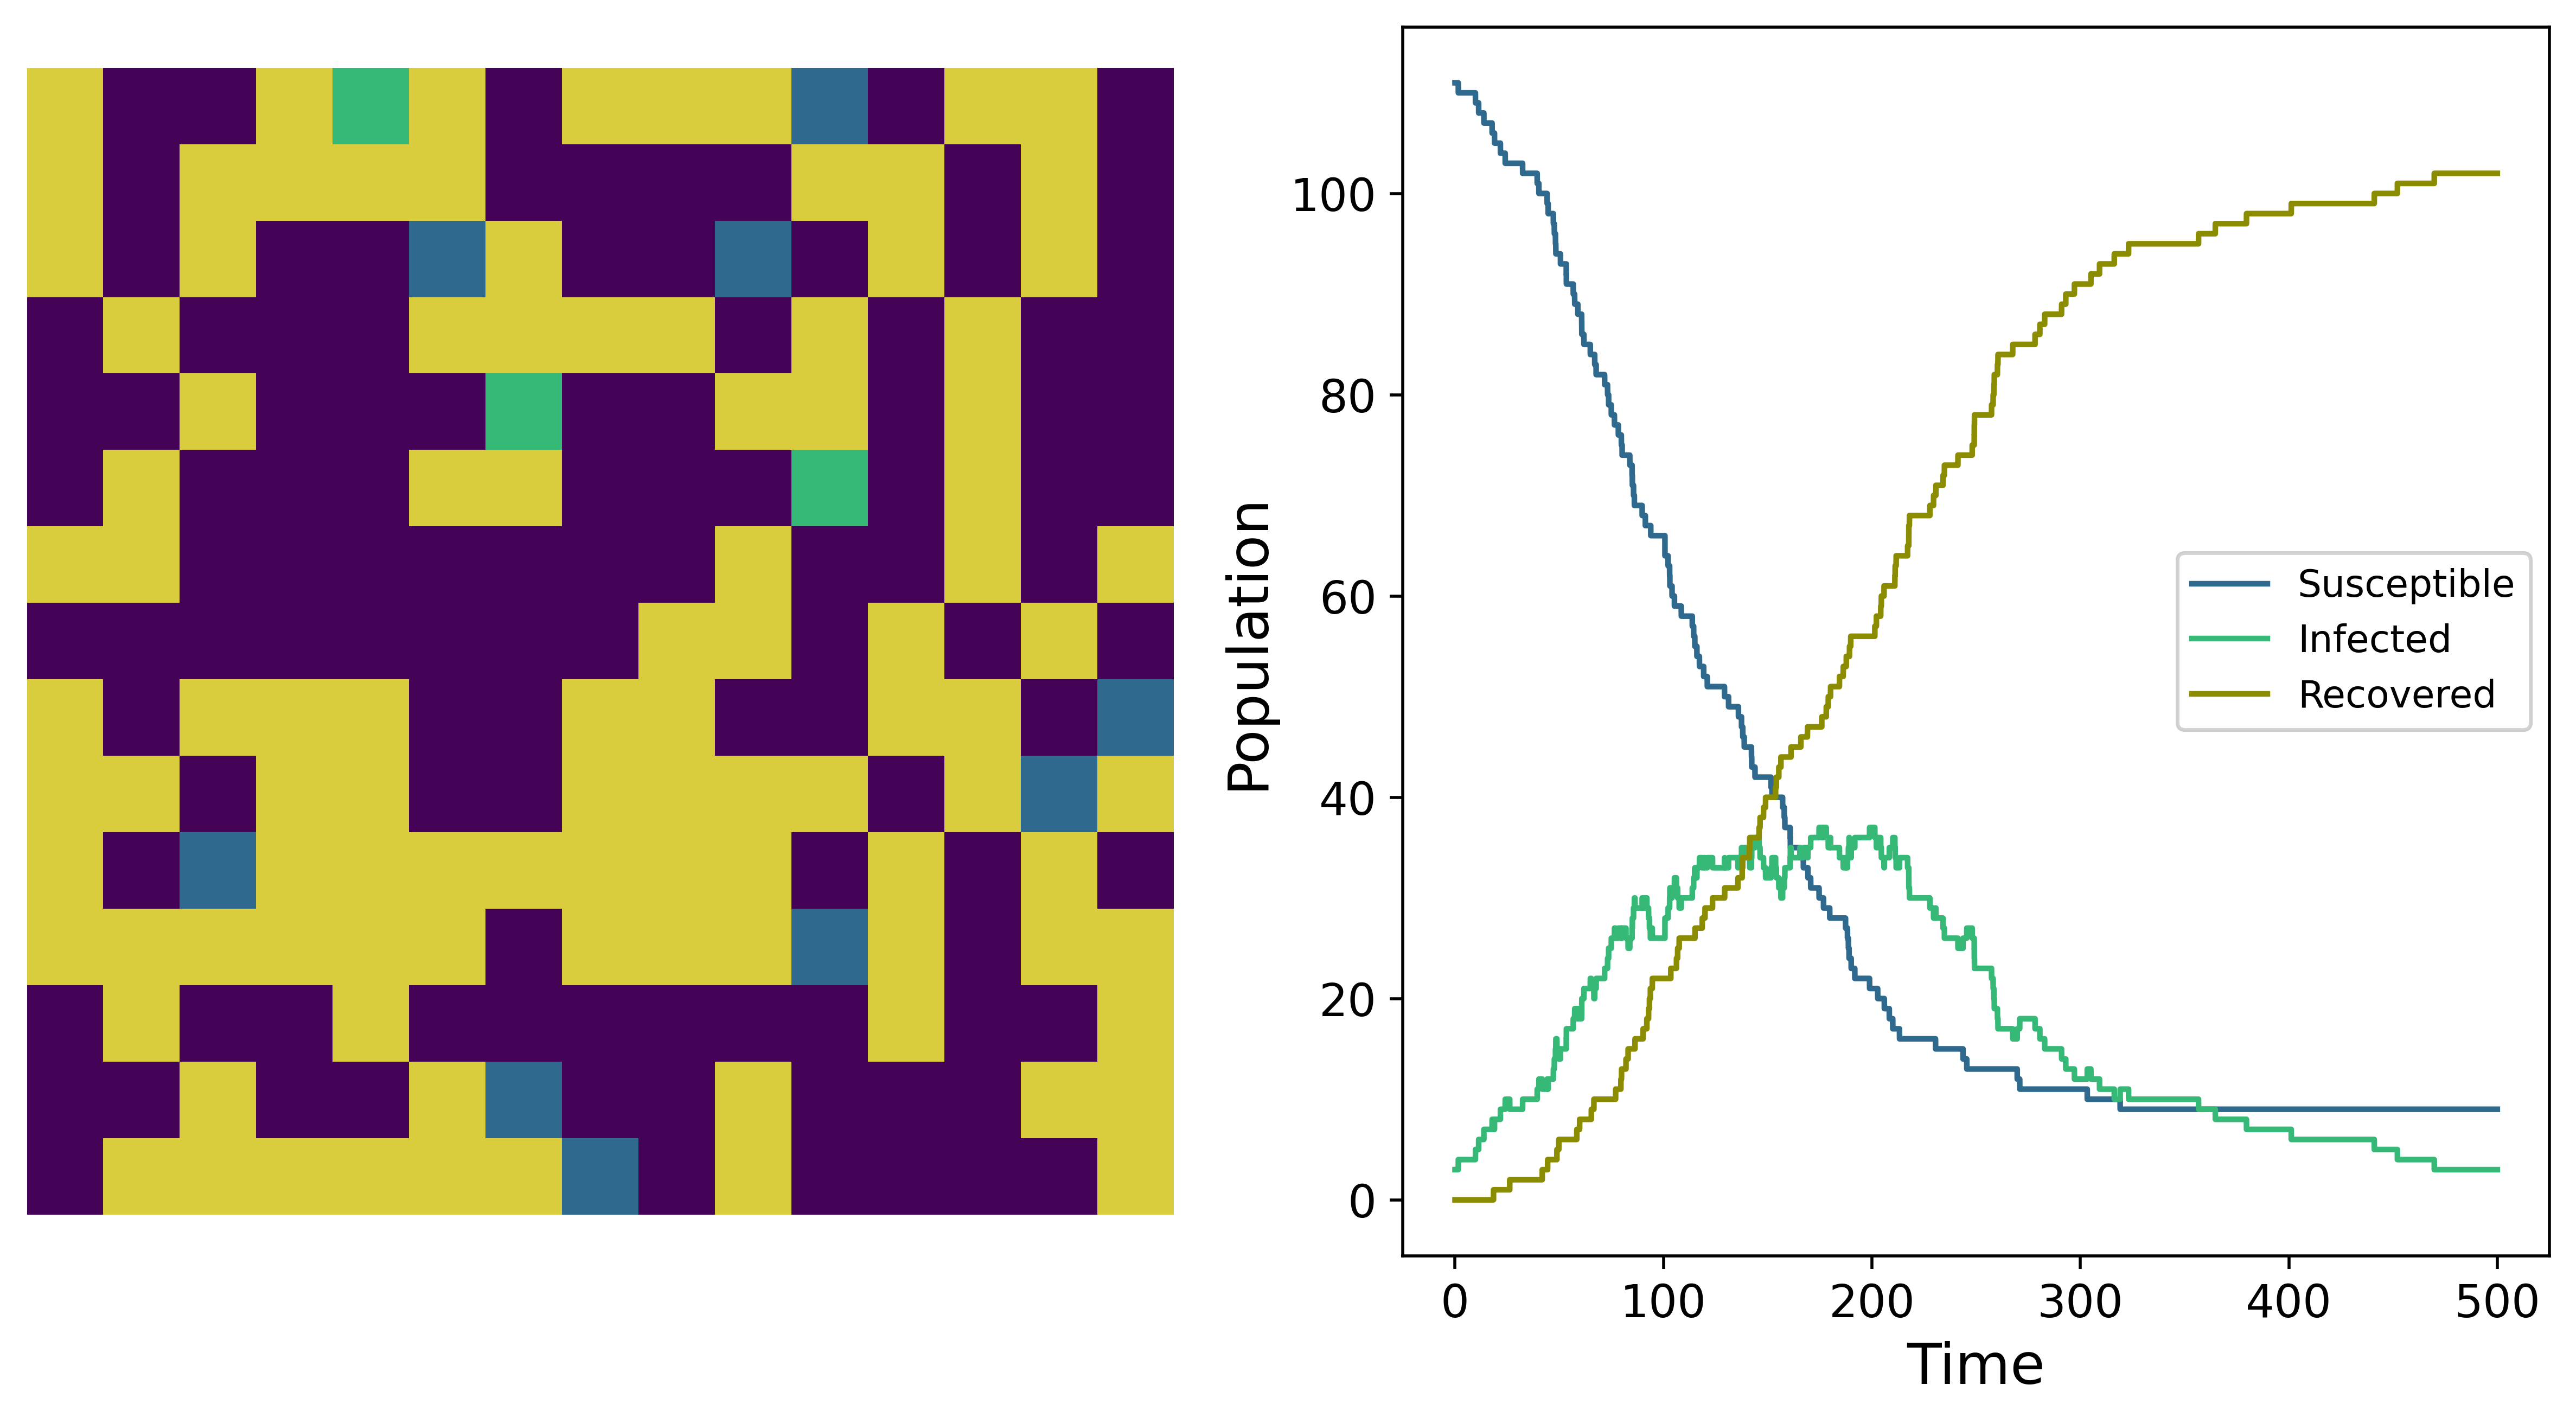

In [8]:
##anim lattice + sir graph

print("simulating")
tic = time.perf_counter()
#for large n and snapshot_num, this will take a long time. for n=15, sn=20 executes in 1min, for n=50, sn=60 executes in 40min
S, I, R, t, A_list, st = SIR_ABM(n=15, snapshot_num=20)
toc = time.perf_counter()
print(f"simulated in {toc-tic:0.4f} seconds")

print("plotting")
tic = time.perf_counter()

fig = plt.figure(figsize=(12,6), dpi=500)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.axis('off')
ax2.set_xlabel('Time', fontsize=15)
ax2.set_ylabel('Population', fontsize=15)
ax2.tick_params(axis='both', labelsize=12)
camera = Camera(fig)

for i in range(len(st)):
    print(f"plot {i+1} out of {len(st)}")
    if len(np.where(A_list[i]==3)[0])==0:
        cmap = colors.ListedColormap(['#440357','#2F698D','#36B877'])
    else:
        cmap = colors.ListedColormap(['#440357','#2F698D','#36B877','#d9cd3d'])
    ax1.imshow(A_list[i], cmap=cmap)

    j = st[i]
    susc, = ax2.plot(t[:j], S[:j], '#2F698D')
    inf, = ax2.plot(t[:j], I[:j], '#36B877')
    rec, = ax2.plot(t[:j], R[:j], '#8c8c01')
    ax2.legend([susc, inf, rec],['Susceptible', 'Infected', 'Recovered'])

    camera.snap()
toc = time.perf_counter()
print(f"generated plots in {toc-tic:0.4f} seconds")

print("saving")
tic = time.perf_counter()
anim = camera.animate()
anim.save('test_anims/test2.mp4', fps=30, progress_callback=lambda i, n: print(f'frame {i+1} out of {len(st)}'),)
toc = time.perf_counter()
print(f"saved in {toc-tic:0.4f} seconds")

$$S_d(t)=\langle S_\text{ABM}(t)\rangle = \frac{1}{N}\sum_{n=1}^N S_\text{ABM}^{(n)}(t)$$
$$I_d(t)=\langle I_\text{ABM}(t)\rangle = \frac{1}{N}\sum_{n=1}^N I_\text{ABM}^{(n)}(t)$$
$$R_d(t)=\langle R_\text{ABM}(t)\rangle = \frac{1}{N}\sum_{n=1}^N R_\text{ABM}^{(n)}(t)$$

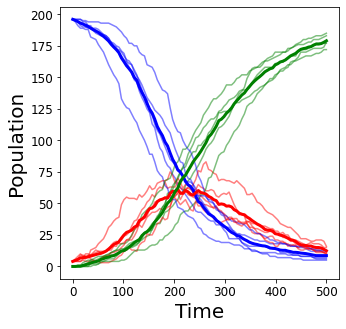

In [302]:
#step 1 : produce averaged model simulation
pr = 0.01
lattice_size = 20
n_simulations = 5
t_end = 5
t = np.linspace(0, t_end/pr, 100)

#lists of outputs from multiple simulations
S_list = []
I_list = []
R_list = []

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Population', fontsize=20)
ax.tick_params(axis='both', labelsize=12)

for i in range(n_simulations):
    S, I, R, t_list, A, st = SIR_ABM(n=lattice_size,pr=pr, T=t_end)
    #interpolate
    f = interpolate.interp1d(t_list, S)
    S_out = f(t)
    f = interpolate.interp1d(t_list, I)
    I_out = f(t)
    f = interpolate.interp1d(t_list, R)
    R_out = f(t)

    ax.plot(t,S_out, 'b', alpha=0.5, label='Susceptible')
    ax.plot(t,I_out, 'r', alpha=0.5,label='Infected')
    ax.plot(t,R_out, 'g', alpha=0.5,label='Recovered')

    #add to lists
    if i == 0:
        S_list = S_out[:,np.newaxis]
        I_list = I_out[:,np.newaxis]
        R_list = R_out[:,np.newaxis]
    else:
        S_list = np.hstack([S_list, S_out[:,np.newaxis]])
        I_list = np.hstack([I_list, I_out[:,np.newaxis]])
        R_list = np.hstack([R_list, R_out[:,np.newaxis]])

#calculate mean at each t
S_d = []
I_d = []
R_d = []
for i in range(len(t)):
    S_avg = sum(S_list[i])/n_simulations
    I_avg = sum(I_list[i])/n_simulations
    R_avg = sum(R_list[i])/n_simulations
    S_d.append(S_avg)
    I_d.append(I_avg)
    R_d.append(R_avg)


ax.plot(t,S_d, 'b', lw=3, label='Susceptible')
ax.plot(t,I_d, 'r', lw=3,label='Infected')
ax.plot(t,R_d, 'g', lw=3, label='Recovered')

$$\frac{\text{d}S_d(t_1)}{\text{d}t}=\frac{S_d(t_2)-S_d(t_1)}{\Delta t},$$
$$\frac{\text{d}S_d(t_i)}{\text{d}t}=\frac{S_d(t_i+1)-S_d(t_i-1)}{2\Delta t}, \quad i=2,\cdots,n-1,$$
$$\frac{\text{d}S_d(t_n)}{\text{d}t}=\frac{S_d(t_n)-S_d(t_n-1)}{\Delta t},$$

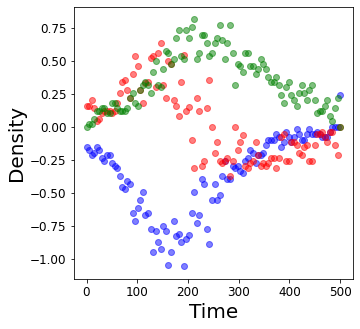

In [303]:
#step 2: calculate numerical derivative at each time point

dt = t[1] - t[0]

S_d = np.array(S_d)
I_d = np.array(I_d)
R_d = np.array(R_d)

St = np.zeros(S_d.shape)
It = np.zeros(I_d.shape)
Rt = np.zeros(R_d.shape)

for i in range(len(t)):
    if i == 0:
        St[i] = (S_d[1]-S_d[0])/dt
        It[i] = (I_d[1]-I_d[0])/dt
        Rt[i] = (R_d[1]-R_d[0])/dt
    elif i != len(t)-1:
        St[i] = (S_d[i+1]-S_d[i-1])/(2*dt)
        It[i] = (I_d[i+1]-I_d[i-1])/(2*dt)
        Rt[i] = (R_d[i+1]-R_d[i-1])/(2*dt)
    else:
        St[i] = (S_d[-1]-S_d[-2])/dt
        St[i] = (I_d[-1]-I_d[-2])/dt
        St[i] = (R_d[-1]-R_d[-2])/dt

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Density', fontsize=20)
ax.tick_params(axis='both', labelsize=12)
ax.plot(t,St, 'bo', alpha=0.5, label='St')
ax.plot(t,It, 'ro', alpha=0.5,label='It')
ax.plot(t,Rt, 'go', alpha=0.5,label='Rt')

## STEP 3
$$
\frac{\text{d}S}{\text{d}t}=\sum_{i=1}^4 \xi_i S^i
$$
$$
\left[\begin{matrix}
\frac{\text{d}S_d(t_1)}{\text{d}t}\\
\frac{\text{d}S_d(t_2)}{\text{d}t}\\
\vdots\\
\frac{\text{d}S_d(t_n)}{\text{d}t}\\
\end{matrix}\right]=\left[\begin{matrix}
S_d(t_1) & S_d^2(t_1) & S_d^3(t_1) & S_d^4(t_1)\\
S_d(t_2) & S_d^2(t_2) & S_d^3(t_2) & S_d^4(t_2)\\
\vdots & \vdots & \vdots & \vdots \\
S_d(t_n) & S_d^2(t_n) & S_d^3(t_n) & S_d^4(t_n)\\
\end{matrix}\right]\left[\begin{matrix}\xi_1\\ \xi_2 \\ \xi_3 \\ \xi_4 \end{matrix}\right]
$$
$$
\frac{\text{d}S_d}{\text{d}t}=\mathbb{\Theta}\xi
$$

In [448]:
#step 4: apply regression to obtain coefficients. least squares on Ax=b,

S_theta = [S_d]
I_theta = [I_d]
R_theta = [R_d]
deg = 4

for i in np.arange(2,deg + 1):
    S_theta.append(S_d**i) 
    I_theta.append(I_d**i)
    R_theta.append(R_d**i)

In [449]:
S_theta = np.transpose(S_theta)
I_theta = np.transpose(I_theta)
R_theta = np.transpose(R_theta)
S_xi = np.linalg.lstsq(S_theta, St, rcond=-1)
I_xi = np.linalg.lstsq(I_theta, It, rcond=-1)
R_xi = np.linalg.lstsq(R_theta, Rt, rcond=-1)

In [467]:
S_xi
I_xi

(array([ 1.91680344e-02, -1.53851050e-03,  3.81803067e-05, -2.99049423e-07]),
 array([6.60728159]),
 4,
 array([5.57345084e+07, 1.06700997e+05, 8.47035229e+02, 1.77150712e+01]))